# Apply Machine Learning Classifiers to PDX RNAseq data

**Gregory Way, 2018**

In the following notebook, I apply three distinct classifiers to patient derived xenograft (PDX) RNAseq data (FPKM).
The first classifier detects Ras activation. For more details about the algorithm and results, refer to [Way et al. 2018](https://doi.org/10.1016/j.celrep.2018.03.046 "Machine Learning Detects Pan-cancer Ras Pathway Activation in The Cancer Genome Atlas"). I also include _TP53_ inactivation predictions. This classifier was previously applied in [Knijnenburg et al. 2018](https://doi.org/10.1016/j.celrep.2018.03.076 "Genomic and Molecular Landscape of DNA Damage Repair Deficiency across The Cancer Genome Atlas"). The third is a classifier that predicts _NF1_ inactivation. We previously applied this in [Way et al. 2017](https://doi.org/10.1186/s12864-017-3519-7 "A machine learning classifier trained on cancer transcriptomes detects NF1 inactivation signal in glioblastoma").

To apply other classifiers (targeting other genes of interest) refer to https://github.com/greenelab/pancancer.

Also note that we have implemented classifiers on a larger scale and made the models accessible to non-computational biologists (see [Project Cognoma](http://cognoma.org)).

## Procedure

1. Load RNAseq matrix (`.RDS`)
  * The matrix is in `sample` x `gene symbol` format (250 x 51,968)
2. Process matrix
  * Take the z-score by gene
3. Load classifier coefficients
  * For both _Ras_, _TP53_, and _NF1_ classifiers
4. Apply each classifier to the input data
  * This also requires additional processing steps to the input data (subsetting to the respective classifier genes)
  * Also note that not all genes are present in the input RNAseq genes.
5. Shuffle the gene expression data (by gene) and apply each classifier to random data

### Important Caveat

Because not all of the classifier genes are found in the input dataset, the classifier probability is not calibrated correctly. The scores should be interpreted as continuous values representing relative gene alterations, and not as a pure probability estimate.

## Output

The output of this notebook are the predicted scores for both classifiers across all samples for real data and shuffled data. This is in the form of a single text file with three columns (`sample_id`, `ras_score`, `tp53_score`, `nf1_score`,  `ras_shuffle`, `tp53_shuffle`, `nf1_shuffle`).

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

from utils import apply_classifier, shuffle_columns

In [2]:
%matplotlib inline

In [3]:
pandas2ri.activate()
readRDS = robjects.r['readRDS']

In [4]:
# Make results directory
try:
    os.makedirs('./results')
except OSError:
    pass

In [5]:
# Load PDX gene expression data in RDS format
file = os.path.join('data', 'raw', '2018-08-24-PPTC_FPKM_matrix_withModelID-250.RDS')

exprs_rds = readRDS(file)
exprs_df = pandas2ri.ri2py(exprs_rds).set_index('gene_short_name').transpose()

print(exprs_df.shape)
exprs_df.head(3)

(250, 51968)


gene_short_name,5S_rRNA,7SK,A-575C2.4,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3
ALL-102,0.0,3.58839,0.537883,4.27196,3.76506,0.0,5.89165,0.905337,0.074723,3.804390e-281,...,42.6210,2.54349,4.53236,6.76070,0.010528,0.0,3.98401,54.4958,12.08540,5.84061
ALL-105,0.0,5.30719,1.062420,1.27740,2.48042,0.0,7.61281,0.979303,0.000000,3.456910e-285,...,44.5727,1.99089,3.62848,6.12268,0.000000,0.0,4.65392,13.3985,8.11452,7.62316
ALL-106,0.0,9.07089,0.885766,1.01986,5.37849,0.0,7.64102,0.604450,0.091972,4.924820e-02,...,20.8279,1.80050,2.22317,10.31110,0.005779,0.0,5.07277,19.0703,14.91710,12.20690


In [6]:
# Transform the gene expression data (z-score by gene)
scaled_fit = StandardScaler().fit(exprs_df)
exprs_scaled_df = pd.DataFrame(scaled_fit.transform(exprs_df),
                               index=exprs_df.index,
                               columns=exprs_df.columns)
exprs_scaled_df.head()

gene_short_name,5S_rRNA,7SK,A-575C2.4,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3
ALL-102,-0.105048,-0.361700,0.181645,-0.078042,0.574897,-0.075873,-0.162188,0.376440,-0.165310,-0.279466,...,-0.093262,0.952890,0.136724,-0.203629,-0.520658,-0.267725,-0.807675,0.860460,1.254975,-1.339925
ALL-105,-0.105048,-0.210517,1.405062,-0.869368,-0.213692,-0.075873,-0.146666,0.456020,-0.186631,-0.279466,...,-0.013189,0.495942,-0.034550,-0.429512,-0.534920,-0.267725,-0.691767,-0.596311,0.290005,-1.050075
ALL-106,-0.105048,0.120531,0.993039,-0.937424,1.565317,-0.075873,-0.146412,0.052715,-0.160388,1.230625,...,-0.987370,0.338508,-0.300838,1.053344,-0.527091,-0.267725,-0.619298,-0.395264,1.943112,-0.304739
ALL-107,-0.105048,-0.312139,0.535203,-0.367528,0.835407,-0.075873,-0.197387,-0.551442,-0.153086,-0.279466,...,0.630482,0.592541,0.200064,-0.511992,-0.527295,-0.267725,-0.499817,-0.086355,1.399810,-0.255763
ALL-108,-0.105048,-0.013088,5.002612,-0.672369,2.896484,-0.075873,-0.202831,-0.471348,-0.180024,-0.279466,...,-0.062655,0.484564,-0.039482,0.660462,-0.528839,-0.267725,-0.477897,0.065422,2.010037,-0.082297


In [7]:
# Shuffle input RNAseq matrix and apply classifiers
exprs_shuffled_df = exprs_scaled_df.apply(shuffle_columns, axis=0)

## Apply Ras Classifier

In [8]:
# Load RAS Classifier
file = os.path.join('data', 'ras_classifier_coefficients.tsv')
ras_coef_df = pd.read_table(file, index_col=0)
ras_coef_df = ras_coef_df.query('abs_val > 0')

print(ras_coef_df.shape)
ras_coef_df.head()

(185, 3)


,feature,weight,abs_val
6702,PBX3,0.139761,0.139761
4592,SPRY2,0.123713,0.123713
6708,C15orf52,0.106100,0.106100
2882,PPP1R3B,0.104700,0.104700
1520,MLPH,0.102069,0.102069


In [9]:
# Apply the Ras classifier to the input RNAseq matrix
ras_scores_df, ras_common_genes_df, ras_missing_genes_df = (
    apply_classifier(coef_df=ras_coef_df, rnaseq_df=exprs_scaled_df)
)

In [10]:
# Determine the extent of coefficient overlap
print('There are a total of {} out of {} genes in common ({}%) between the datasets'
      .format(ras_common_genes_df.shape[0],
              ras_coef_df.shape[0],
              round(ras_common_genes_df.shape[0] / ras_coef_df.shape[0] * 100, 2)))

There are a total of 173 out of 185 genes in common (93.51%) between the datasets


In [11]:
# Which Genes are Missing?
ras_missing_genes_df

,feature,weight,abs_val
6994,KIAA1539,0.069202,0.069202
5954,C12orf11,0.063514,0.063514
7023,ZNF322A,0.048071,0.048071
8033,log10_mut,0.048028,0.048028
6042,C17orf63,0.035493,0.035493
4795,C17orf37,-0.034015,0.034015
1672,C9orf86,0.028749,0.028749
4927,BRP44,-0.026352,0.026352
52,LOC96610,-0.020048,0.020048
7281,FAM125B,0.018148,0.018148


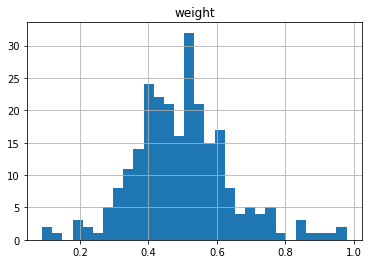

In [12]:
# Distribution of predictions of the Ras Classifier applied to input data
ras_scores_df.T.hist(bins=30);

### Apply Ras Classifier to Shuffled Data

In [13]:
# Apply the Ras classifier to the input RNAseq matrix 
ras_shuffle_scores_df, ras_shuffle_common_genes_df, ras_shuffle_missing_genes_df = (
    apply_classifier(coef_df=ras_coef_df, rnaseq_df=exprs_shuffled_df)
)

## Apply TP53 Classifier

In [14]:
# Load RAS Classifier
file = os.path.join('data', 'tp53_classifier_coefficients.tsv')
tp53_coef_df = pd.read_table(file, index_col=0)
tp53_coef_df = tp53_coef_df.query('abs_val > 0')

print(tp53_coef_df.shape)
tp53_coef_df.head()

(319, 3)


,feature,weight,abs_val
6922,DDB2,-0.212359,0.212359
6472,AEN,-0.195592,0.195592
3464,RPS27L,-0.181545,0.181545
2341,MDM2,-0.145332,0.145332
4346,BAX,-0.125992,0.125992


In [15]:
# Apply the TP53 classifier to the input RNAseq matrix
tp53_scores_df, tp53_common_genes_df, tp53_missing_genes_df = (
    apply_classifier(coef_df=tp53_coef_df, rnaseq_df=exprs_scaled_df)
)

In [16]:
# Determine the extent of coefficient overlap
print('There are a total of {} out of {} genes in common ({}%) between the datasets'
      .format(tp53_common_genes_df.shape[0],
              tp53_coef_df.shape[0],
              round(tp53_common_genes_df.shape[0] / tp53_coef_df.shape[0] * 100, 2)))

There are a total of 301 out of 319 genes in common (94.36%) between the datasets


In [17]:
# Which Genes are Missing?
tp53_missing_genes_df

,feature,weight,abs_val
4274,C19orf2,0.044708,0.044708
7355,C6orf192,-0.040536,0.040536
7856,C17orf68,-0.033953,0.033953
7603,KIAA1804,0.031246,0.031246
6210,KIAA0415,0.026226,0.026226
4984,C19orf50,0.026029,0.026029
7669,FTHL3,0.022275,0.022275
2958,C20orf43,0.022058,0.022058
3682,KIAA0090,0.019398,0.019398
6322,KIAA1632,-0.017291,0.017291


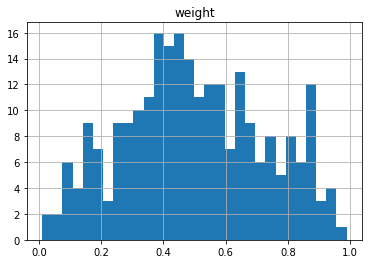

In [18]:
# Distribution of predictions of the TP53 Classifier applied to input data
tp53_scores_df.T.hist(bins=30);

### Apply TP53 Classifier to Shuffled Data

In [19]:
# Apply the Ras classifier to the input RNAseq matrix 
tp53_shuffle_scores_df, tp53_shuffle_common_genes_df, tp53_shuffle_missing_genes_df = (
    apply_classifier(coef_df=tp53_coef_df, rnaseq_df=exprs_shuffled_df)
)

## Apply NF1 Classifier

In [20]:
# Load NF1 Classifier
file = os.path.join('data', 'nf1_classifier_coefficients.tsv')
nf1_coef_df = pd.read_table(file, index_col=0)
nf1_coef_df = nf1_coef_df.query('abs_val > 0')

print(nf1_coef_df.shape)
nf1_coef_df.head()

(55, 3)


,feature,weight,abs_val
3815,SPRED2,0.165174,0.165174
7151,GOSR1,-0.155423,0.155423
7894,KCNS3,0.067975,0.067975
1483,WDR45L,0.067480,0.067480
856,FCGRT,-0.062596,0.062596


In [21]:
# Apply the NF1 classifier to the input RNAseq matrix
nf1_scores_df, nf1_common_genes_df, nf1_missing_genes_df = (
    apply_classifier(coef_df=nf1_coef_df, rnaseq_df=exprs_scaled_df)
)

In [22]:
# Determine the extent of coefficient overlap
print('There are a total of {} out of {} genes in common ({}%) between the datasets'
      .format(nf1_common_genes_df.shape[0],
              nf1_coef_df.shape[0],
              round(nf1_common_genes_df.shape[0] / nf1_coef_df.shape[0] * 100, 2)))

There are a total of 53 out of 55 genes in common (96.36%) between the datasets


In [23]:
# Which Genes are Missing?
nf1_missing_genes_df

,feature,weight,abs_val
1483,WDR45L,0.067480,0.067480
1819,SFRS9,0.003948,0.003948


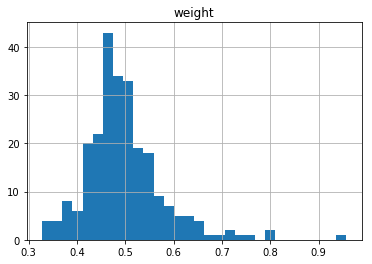

In [24]:
# Distribution of predictions of the NF1 Classifier applied to input data
nf1_scores_df.T.hist(bins=30);

### Apply NF1 Classifier to Shuffled Data

In [25]:
# Apply the NF1 classifier to the input RNAseq matrix 
nf1_shuffle_scores_df, nf1_shuffle_common_genes_df, nf1_shuffle_missing_genes_df = (
    apply_classifier(coef_df=nf1_coef_df, rnaseq_df=exprs_shuffled_df)
)

## Combine Ras and TP53 predictions and output to file

In [26]:
results_list = [ras_scores_df.T, tp53_scores_df.T, nf1_scores_df.T,
                ras_shuffle_scores_df.T, tp53_shuffle_scores_df.T,
                nf1_shuffle_scores_df.T]

all_results = pd.concat(results_list, axis='columns').reset_index()
all_results.columns = ['sample_id', 'ras_score', 'tp53_score', 'nf1_score',
                       'ras_shuffle', 'tp53_shuffle', 'nf1_shuffle']

file = os.path.join('results', 'classifier_scores.tsv')
all_results.to_csv(file, sep='\t', index=False)

all_results.head()

,sample_id,ras_score,tp53_score,nf1_score,ras_shuffle,tp53_shuffle,nf1_shuffle
0,ALL-102,0.516375,0.447161,0.512023,0.473015,0.628489,0.477897
1,ALL-105,0.406924,0.537289,0.452825,0.424123,0.324875,0.546235
2,ALL-106,0.437307,0.380876,0.419952,0.397130,0.500320,0.479159
3,ALL-107,0.370617,0.444103,0.458372,0.490617,0.661135,0.502846
4,ALL-108,0.435229,0.460351,0.455453,0.472857,0.673772,0.399693


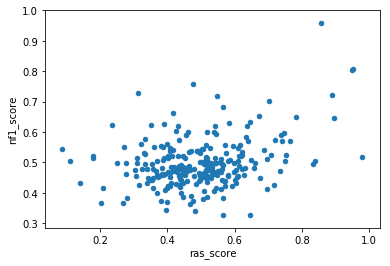

In [27]:
all_results.plot(kind='scatter', x='ras_score', y='nf1_score');